## Import das bibliotecas utilizadas


In [1]:
import pandas as pd
import numpy as np
import itertools
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics



### Carregamento dos dados para a parte de Modelagem

In [2]:
df_transposed_copy_inputting_v19 = pd.read_csv(r'Projeto/Data/Output/df_transposed_copy_inputting_v19.csv')


## Modelagem

Modelos de Forecasting são divididos em partes pré e pós período desejado para previsão. Os períodos utilizados devem ser equiparáveis ao tipo de questão analisada.

In [3]:
df_model = df_transposed_copy_inputting_v19.copy()

In [4]:
df_model['year'] = pd.to_datetime(df_model['year'], format='ISO8601')


In [5]:
df_model = df_model.rename(columns = {'year': 'ds'})
df_model.head(1)

,ds,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,...,Emerging and Developing Europe,Emerging market and developing economies,Euro area,European Union,Latin America and the Caribbean,Major advanced economies (G7),Middle East and Central Asia,Other advanced economies,Sub-Saharan Africa,World
0,1980-01-01,4.345486,2.7,-5.4,2.877381,2.4,8.2,0.7,5.29,5.399885,...,-0.8,3.3,3.988678,1.8,6.4,0.9,-1.9,3.8,3.99192,2.1


#### Training and Test set

In [6]:
test_years = 5
train_data = df_model.iloc[:-test_years, :]
#train_data.tail(1)
test_data = df_model.iloc[-test_years:, :]
#test_data.head(1)

### FB Prophet sem regressor


A biblioteca Prophet é uma ferramenta de previsão de séries temporais desenvolvida pelo time de Ciência de Dados do Facebook. Ela é baseada em um modelo aditivo onde dentências não lineares são ajustadas com sazonalidade anual, semanal e diária, além de efeitos de feriados. Ela funciona com séries temporais que possuem efeitos sazonais forte e várias temporadas de dados históricos. A biblioteca é robusta a dados faltantes e mudanças na tendência, e geralmente lida bem com os outliers. 

Diferente dos demais modelos é necessário realizar um pequeno tratamento dos dados nos datasets de treino e teste, renomeando a coluna onde contém as datas para 'ds' e os países devendo ser renomeados para 'y'. 


In [7]:
df_pred_prophet = pd.DataFrame()

for country in df_model.columns:
    train_data_prophet = pd.DataFrame({
        'ds': train_data['ds'],
        'y': train_data[country]
    })
    #Creating the model
    model_prophet = Prophet(
        growth='linear',
        seasonality_mode='additive',
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.1,
        seasonality_prior_scale=4,
    )
    model_prophet.fit(train_data_prophet)


    future = model_prophet.make_future_dataframe(periods=test_data.shape[0], freq='YS')  
    forecast = model_prophet.predict(future)
    df_pred_prophet = pd.concat([df_pred_prophet, pd.DataFrame(forecast[['yhat']][-5:].values, columns=[country])], axis=1)

11:08:17 - cmdstanpy - INFO - Chain [1] start processing


11:08:26 - cmdstanpy - INFO - Chain [1] done processing
11:08:26 - cmdstanpy - INFO - Chain [1] start processing
11:08:27 - cmdstanpy - INFO - Chain [1] done processing
11:08:27 - cmdstanpy - INFO - Chain [1] start processing
11:08:28 - cmdstanpy - INFO - Chain [1] done processing
11:08:28 - cmdstanpy - INFO - Chain [1] start processing
11:08:28 - cmdstanpy - INFO - Chain [1] done processing
11:08:28 - cmdstanpy - INFO - Chain [1] start processing
11:08:29 - cmdstanpy - INFO - Chain [1] done processing
11:08:29 - cmdstanpy - INFO - Chain [1] start processing
11:08:29 - cmdstanpy - INFO - Chain [1] done processing
11:08:30 - cmdstanpy - INFO - Chain [1] start processing
11:08:30 - cmdstanpy - INFO - Chain [1] done processing
11:08:30 - cmdstanpy - INFO - Chain [1] start processing
11:08:31 - cmdstanpy - INFO - Chain [1] done processing
11:08:31 - cmdstanpy - INFO - Chain [1] start processing
11:08:31 - cmdstanpy - INFO - Chain [1] done processing
11:08:31 - cmdstanpy - INFO - Chain [1] 

#### KPIS de Avaliação do Modelo Prophet
 Indicadores para medir a performance do modelo. MAE e RSME são indicadores de performance para modelos de regressão com variáveis dependentes contínuas. Não existem indicadores considerados 'perfeitos', existem os indicadores melhores apropriados para o problema analisado.

 - MAE - (Mean Absolute Error) É um indicador mais interpretável, utilizado quando a série temporal trata de taxas, porcentagens.
- RSME -  (Root Square Mean Error) São utilizados para modelos com outliers/extremos.
- MAPE - (Mean Absolute Percentage Error) Apesar de tratar os erros de forma absoluta é considerado um indicador mais agradável para comunicar a respeito do modelo. 

In [8]:
df_pred_prophet[country].index = test_data[country].index
df_pred_prophet.drop(columns='ds', inplace = True)
test_data_drop = test_data.copy()
test_data_drop.drop(columns='ds', inplace = True)
df_pred_prophet.index = test_data_drop.index
df_model_drop = df_model.copy()
df_model_drop.drop(columns = 'ds', inplace = True)

In [9]:

def MAPE(df_model_true, df_model_pred):
    df_model_true, df_model_pred = np.array(df_model_true), np.array(df_model_pred)
    return np.mean(np.abs((df_model_true - df_model_pred)/ df_model_true)) *100

metrics_results = []
# Loop para métricas mae, rmse e mape
for country in df_model_drop.columns:
    mae = round(mean_absolute_error(test_data_drop[country].values, df_pred_prophet[country].values),2)
    rmse = round(np.sqrt(mean_squared_error(test_data_drop[country].values, df_pred_prophet[country].values)), 2)
    mape = MAPE(test_data_drop[country].values, df_pred_prophet[country].values)
    
    print(f"Country: {country}")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"MAPE: {mape}")
    print("=============")

    metrics_results.append({
        "Country": country,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape
    })

metrics_prophet = pd.DataFrame(metrics_results)
metrics_prophet.to_csv('Projeto/Data/Metrics/metrics_prophet.csv', index = True)

Country: Afghanistan
MAE: 0.71
RMSE: 0.79
MAPE: 14.084966713674305
Country: Albania
MAE: 0.92
RMSE: 1.18
MAPE: 26.98779835834419
Country: Algeria
MAE: 0.67
RMSE: 0.71
MAPE: 32.660726095765234
Country: Andorra
MAE: 0.86
RMSE: 0.99
MAPE: 57.14596550829979
Country: Angola
MAE: 0.67
RMSE: 0.77
MAPE: 16.82090112098837
Country: Antigua and Barbuda
MAE: 3.19
RMSE: 3.32
MAPE: 90.9459462496285
Country: Argentina
MAE: 0.52
RMSE: 0.6
MAPE: 26.00371351859864
Country: Armenia
MAE: 3.45
RMSE: 3.48
MAPE: 75.39129410404672
Country: Aruba
MAE: 1.18
RMSE: 1.34
MAPE: 103.1382072661413
Country: Australia
MAE: 0.36
RMSE: 0.43
MAPE: 18.20758249763988
Country: Austria
MAE: 0.38
RMSE: 0.43
MAPE: 23.33615540349978
Country: Azerbaijan
MAE: 6.85
RMSE: 6.94
MAPE: 268.4477275680079
Country: The Bahamas
MAE: 1.56
RMSE: 1.83
MAPE: 97.13806209508272
Country: Bahrain
MAE: 0.53
RMSE: 0.63
MAPE: 18.9294695039815
Country: Bangladesh
MAE: 0.28
RMSE: 0.31
MAPE: 4.091357805964675
Country: Barbados
MAE: 2.21
RMSE: 2.31
MAPE:

#### Export forecastspara Prophet

In [10]:
## Export forecast

df_pred_prophet.to_csv('Projeto/Data/Output/predictions_prophet_all.csv', index = True)

### Avaliando Métricas do Prophet

DataFrame: Prophet
Métrica: MAE
mean      1.672544
median    0.965000
std       1.991240
Name: MAE, dtype: float64


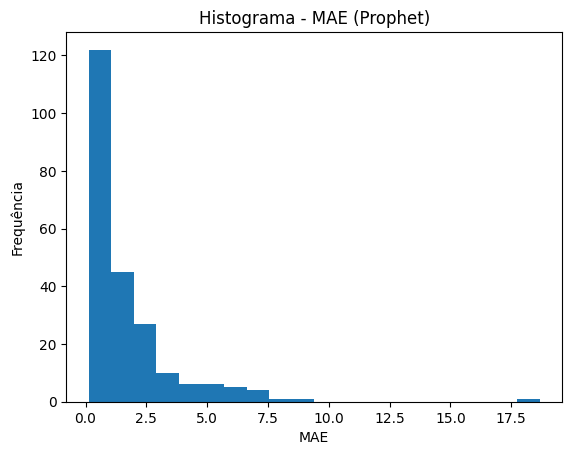



Top 20 MAE (Prophet):
                     Country    MAE   RMSE        MAPE
71                    Guyana  18.67  19.08  319.750221
193                    Yemen   8.78   8.91  182.031020
53         Equatorial Guinea   7.84   8.86  477.512977
96                   Lebanon   7.27   7.49   74.596528
11                Azerbaijan   6.85   6.94  268.447728
190                Venezuela   6.76   7.00  705.678526
161  Republic of South Sudan   6.62   6.85  147.991960
171               Tajikistan   6.31   6.35  154.885697
141                    Qatar   6.29   6.43  229.622408
80                      Iraq   6.18   7.19  251.137551
132                    Palau   6.03   6.41  129.717707
121                    Nauru   5.71   6.67  265.859961
179             Turkmenistan   5.59   5.63  243.390143
118               Mozambique   5.06   5.75   52.510004
63                   Georgia   5.01   5.06   96.847447
102                Macao SAR   4.95   8.55   46.992342
199                Caribbean   4.92   6.7

In [11]:

# Lista de métricas
metrics = ['MAE']

# Dicionário de DataFrames com seus respectivos nomes
dataframes = {
    'Prophet': metrics_prophet,
}

# Iterar sobre os DataFrames e as métricas
for df_name, df in dataframes.items():
    print(f"DataFrame: {df_name}")
    
    for metric in metrics:
        print(f"Métrica: {metric}")
        
        # Agregar as estatísticas
        aggregated = df[metric].agg(['mean', 'median', 'std'])
        print(aggregated)
        
        # Gerar histograma
        plt.hist(df[metric], bins=20)
        plt.title(f"Histograma - {metric} ({df_name})")
        plt.xlabel(metric)
        plt.ylabel("Frequência")
        plt.show()

        print("\n")

    # Mostrar os top 20 valores maiores de MAE
    top_20 = df.sort_values(by='MAE', ascending=False).head(20)
    print(f"Top 20 MAE ({df_name}):\n{top_20}\n")


### Cross-validation

A ferramenta de validação cruzada do Prophet permite medir o erro de previsão usando dados históricos. Isso é feito selecionando pontos de corte na história e, para cada um deles, ajustando o modelo usando apenas os dados até esse ponto de corte. Podemos então comparar os valores previstos com os valores reais. <br/><br/>
O procedimento de validação cruzada pode ser feito automaticamente para uma série de cortes históricos usando a função cross_validation. Especificamos o horizonte de previsão (horizon), e opcionalmente o tamanho do período inicial de treinamento (initial) e o espaçamento entre as datas de corte (period). <br/><br/>
Por padrão, o período inicial de treinamento é definido como três vezes o horizonte, e os cortes são feitos a cada meio horizonte. A saída da função cross_validation é um DataFrame com os valores verdadeiros y e os valores previstos fora da amostra yhat, em cada data simulada de previsão e para cada data de corte. Em particular, uma previsão é feita para cada ponto observado entre o corte e o corte + horizonte. Este DataFrame pode então ser usado para calcular medidas de erro de yhat vs y.

In [14]:


df_metrics_cv = pd.DataFrame()

for country in df_model.columns:
    train_data_prophet_cv = pd.DataFrame({
        'ds': train_data['ds'],
        'y': train_data[country]
    })
    
    model_prophet_cv = Prophet(
        growth='linear',
        seasonality_mode='additive',
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.1,
        seasonality_prior_scale=4,
    )
    model_prophet_cv.fit(train_data_prophet_cv)
    # Realize a validação cruzada
    df_cv = cross_validation(model_prophet_cv, initial='365 days', parallel='processes', horizon='1825 days')
    
    # Calcule as métricas para cada fold da validação cruzada
    df_metrics_country = performance_metrics(df_cv)
    df_metrics_country['country'] = country
    
    df_metrics_cv = pd.concat([df_metrics_cv, df_metrics_country], ignore_index=True)



11:10:08 - cmdstanpy - INFO - Chain [1] start processing
11:10:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:10:13 - cmdstanpy - INFO - Chain [1] start processing
11:10:13 - cmdstanpy - INFO - Chain [1] start processing
11:10:13 - cmdstanpy - INFO - Chain [1] start processing
11:10:13 - cmdstanpy - INFO - Chain [1] start processing
11:10:14 - cmdstanpy - INFO - Chain [1] done processing
11:10:14 - cmdstanpy - INFO - Chain [1] start processing
11:10:34 - cmdstanpy - INFO - Chain [1] done processing
11:10:34 - cmdstanpy - INFO - Chain [1] start processing
11:10:36 - cmdstanpy - INFO - Chain [1] done processing
11:10:36 - cmdstanpy - INFO - Chain [1] start processing
11:10:40 - cmdstanpy - INFO - Chain [1] done processing
11:10:41 - cmdstanpy - INFO - Chain [1] start processing
11:10:45 - cmdstanpy - INFO - Chain [1] done processing
11:10:45 - cmdstanpy - INFO - Chain [1] start p

In [23]:
# Calcule a média das métricas para cada país
average_metrics_per_country_prophet = df_metrics_cv.groupby('country').mean()
average_metrics_per_country_prophet.drop(['ds'], axis=0, inplace = True)
# Salve as métricas em um arquivo ou faça o que for necessário
average_metrics_per_country_prophet.to_csv('cv_metrics_prophet.csv', index=True)
